In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

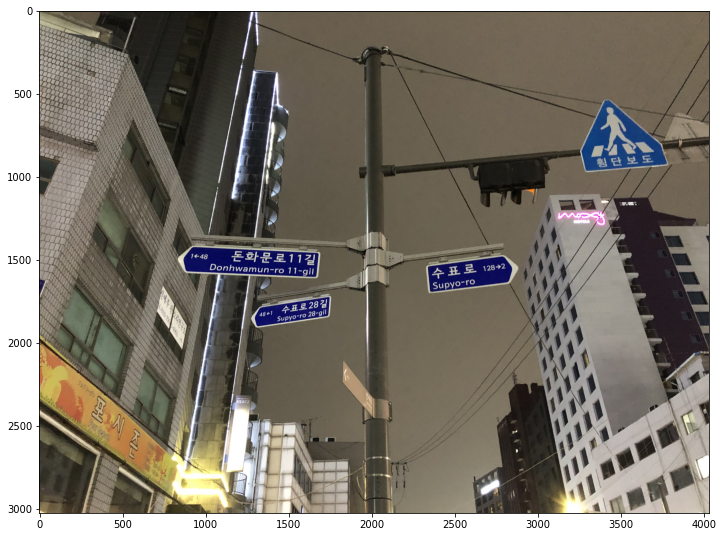

In [2]:
img_ori = cv2.imread('./images/sign9.jpg')

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB))

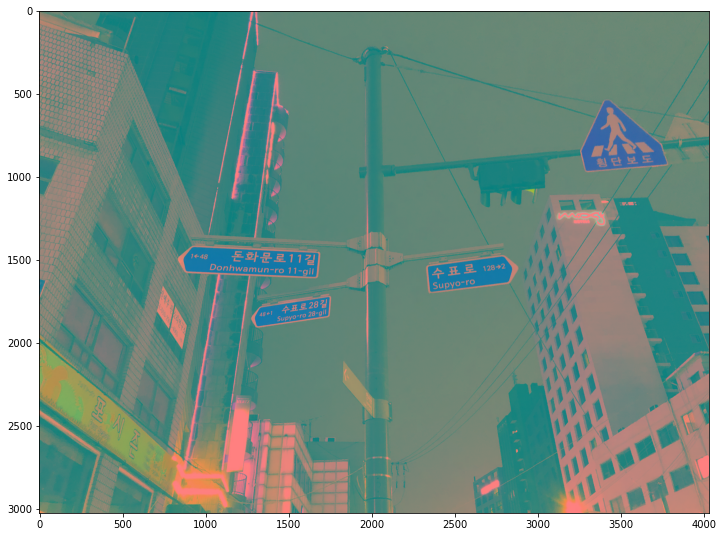

In [3]:
YCC = cv2.cvtColor(img_ori, cv2.COLOR_BGR2YCrCb)

plt.figure(figsize=(12, 10))
plt.imshow(YCC)

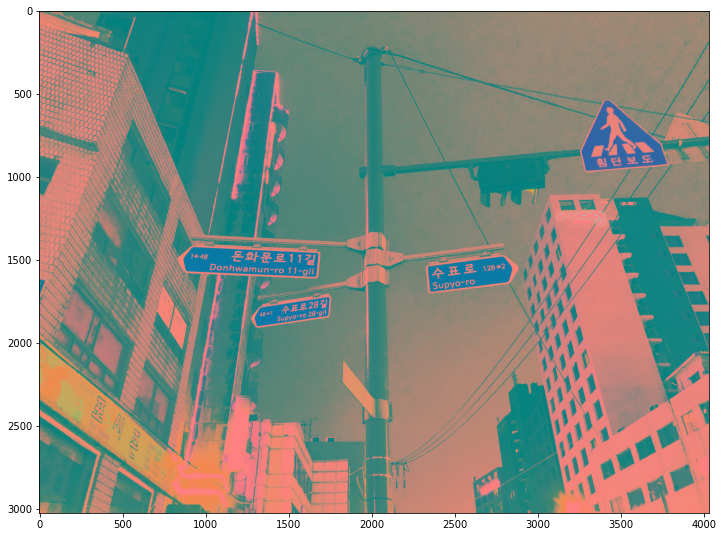

In [4]:
YCC_2d = YCC[:,:,0]
YCC[:,:,0] = cv2.equalizeHist(YCC_2d)

RGB = cv2.cvtColor(YCC, cv2.COLOR_YCrCb2BGR)

YCC = cv2.cvtColor(RGB, cv2.COLOR_BGR2YCrCb)

plt.figure(figsize=(12, 10))
plt.imshow(YCC)

160
mean : 121.12429007096665
max : 200


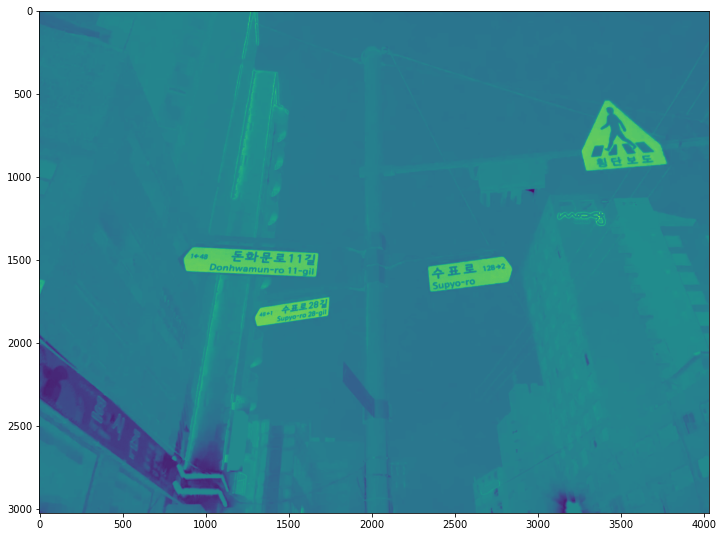

In [5]:
YCC_2d = YCC[:,:,2]
blue_mean = np.mean(YCC_2d)
blue_max = np.max(YCC_2d)
Threshold = int((blue_mean + blue_max) / 2)
print(Threshold)
print('mean : {}'.format(blue_mean))
print('max : {}'.format(blue_max))

plt.figure(figsize=(12, 10))
plt.imshow(YCC_2d)

In [6]:
# 1 - mean = 144, max = 177, Threshold = 160 (145~165)
# 2 - mean = 127, max = 210, Threshold = 180 (140~190)
# 3 - mean = 145, max = 209, Threshold = 175 (170~190)
# 4 - mean = 135, max = 161, Threshold = impossible
# 5 - mean = 119, max = 202, Threshold = 140 (130~150)
# 6 - mean = 131, max = 155, Threshold = 140 (135~145)
# 7 - mean = 126, max = 157, Threshold = 130 (125~130)
# 8 - mean = 125, max = 161, Threshold = 135 (130~135)
# 9 - mean = 121, max = 203, Threshold = 160 (130~160)

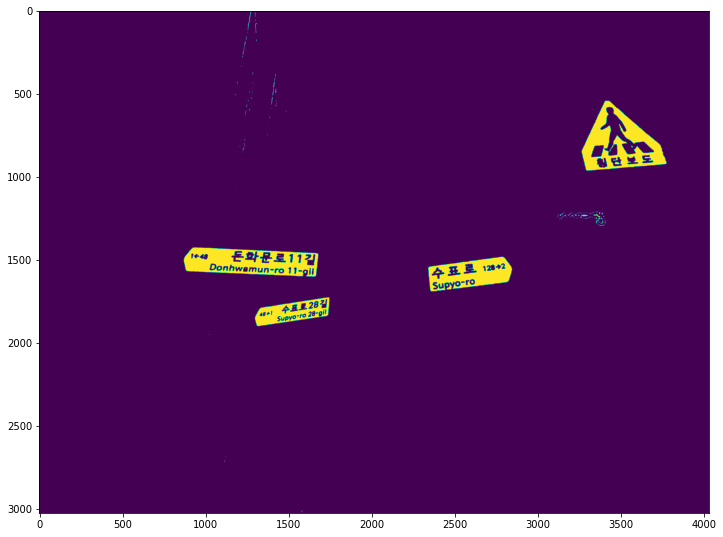

In [7]:
Threshold_YCC = cv2.threshold(YCC_2d, Threshold-8, 255, cv2.THRESH_BINARY)
mask_YCC = np.repeat(np.expand_dims(Threshold_YCC[1], axis=2), 3, axis=2).astype(np.uint8)

plt.figure(figsize=(12, 10))
plt.imshow(Threshold_YCC[1])

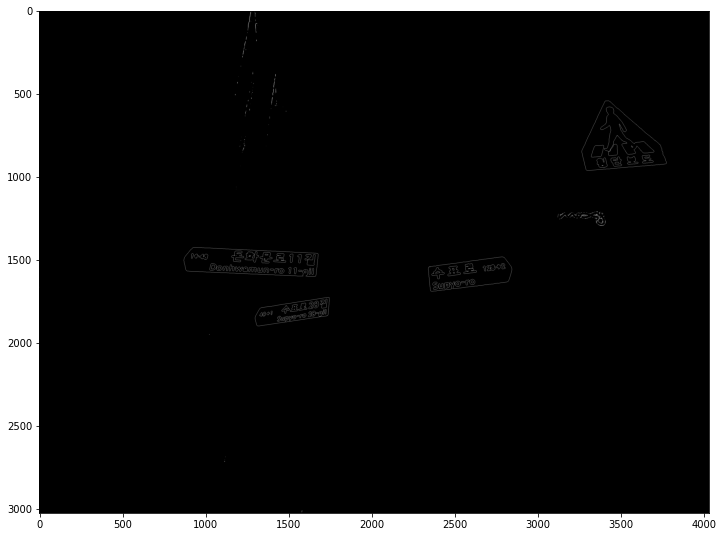

In [8]:
contours, _  = cv2.findContours(
    Threshold_YCC[1], 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

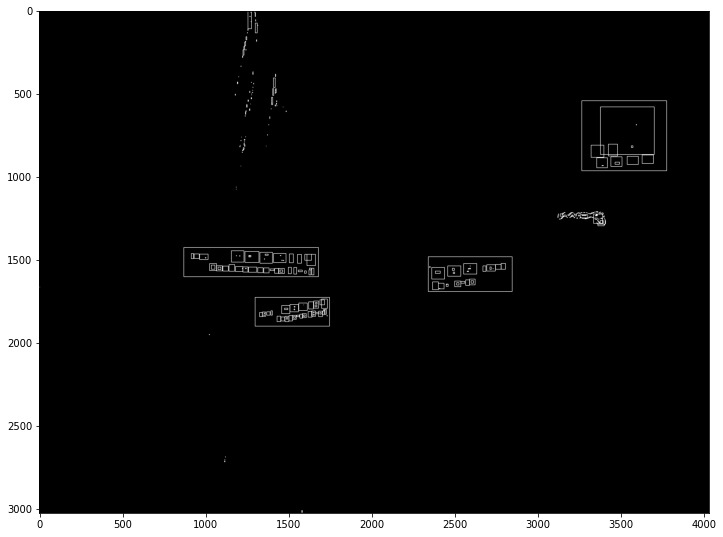

In [9]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

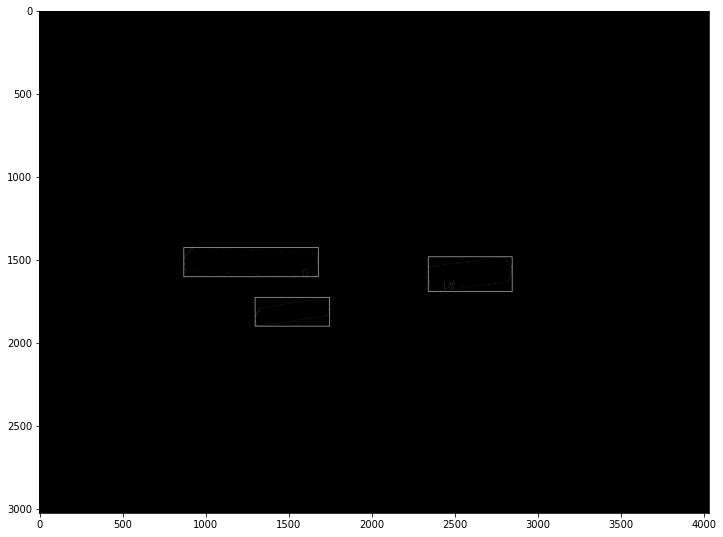

In [10]:
MIN_AREA = (width * height) / 160 #80000
MAX_AREA = (width * height) / 10
MIN_RATIO, MAX_RATIO = 1.5, 10

possible_contours = []

for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if MIN_AREA < area < MAX_AREA \
    and MIN_RATIO < ratio < MAX_RATIO:
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:   
    cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

460 110
504 156
806 147


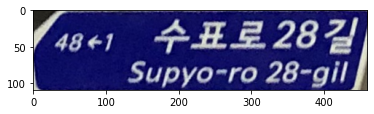

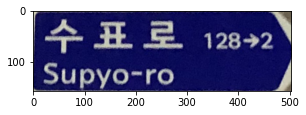

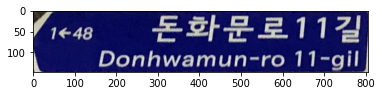

In [11]:
for idx, d in enumerate(possible_contours):
    rect = cv2.minAreaRect(d['contour'])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    sorted_box = sorted(box, key=lambda x : x[0])
    sorted_box[0:2] = sorted(sorted_box[0:2], key=lambda x : x[1])
    sorted_box[2:4] = sorted(sorted_box[2:4], key=lambda x : x[1])
    
    box_width = int(distance.euclidean(sorted_box[0], sorted_box[2]))
    box_height = int(distance.euclidean(sorted_box[0], sorted_box[1]))
    
    print(box_width, box_height)
    
    srcPoint = np.array([sorted_box[0], sorted_box[2], sorted_box[3], sorted_box[1]], dtype=np.float32)
    dstPoint = np.array([[0,0], [box_width, 0], [box_width, box_height], [0, box_height]], dtype=np.float32)

    matrix = cv2.getPerspectiveTransform(srcPoint, dstPoint)

    result = cv2.warpPerspective(img_ori, matrix, (box_width, box_height))

    plt.figure(figsize=(6, 5))
    plt.subplot(len(possible_contours), 1, idx+1)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))